# R-R1: 2D UAV Simulator (Colab)

This notebook runs a beginner-friendly 2D quadcopter simulator (x, z, vx, vz, theta, omega) with simple PD controllers.

Outputs: `flight_log.csv`, plots in `plots/`, and computed metrics (RMSE, overshoot, settling time).

**How to use:** Runtime -> Run all. Download artifacts from the left Files pane or use the provided download links.


In [1]:
!pip install --quiet numpy pandas matplotlib scipy

import os
print('Setup complete.')

Setup complete.


In [2]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


m = 1.0          # mass (kg)
Iyy = 0.02       # rotational inertia around pitch axis (kg*m^2)
g = 9.81         # gravity (m/s^2)
max_thrust = 20.0   # N
max_torque = 1.0    # N*m

T_sim = 10.0     # total time (s)
dt = 0.01        # time step (s)
n_steps = int(T_sim / dt) + 1
time = np.linspace(0, T_sim, n_steps)

# Controller gains
Kp_z = 8.0
Kd_z = 3.0
Kp_x = 1.5
Kd_x = 0.8
Kp_theta = 6.0
Kd_theta = 1.0

# Reference trajectories
def references(t):
    z_ref = 0.0 if t < 0.5 else 1.0
    x_ref = 0.0 if t < 2.0 else 1.0
    vx_ref = 0.0
    vz_ref = 0.0
    return x_ref, z_ref, vx_ref, vz_ref

# State initialization: [x, z, vx, vz, theta, omega]
state = np.zeros(6)

cols = ['t','x','z','vx','vz','theta','omega','thrust','torque','x_ref','z_ref']
log = []

for i, t in enumerate(time):
    x, z, vx, vz, theta, omega = state
    x_ref, z_ref, vx_ref, vz_ref = references(t)

    # Altitude PD -> thrust
    err_z = z_ref - z
    err_vz = vz_ref - vz
    a_command_z = Kp_z * err_z + Kd_z * err_vz
    thrust_unclipped = m * (g + a_command_z) / (np.cos(theta) + 1e-6)
    thrust = np.clip(thrust_unclipped, 0.0, max_thrust)

    # Lateral PD -> desired theta
    err_x = x_ref - x
    err_vx = vx_ref - vx
    ax_des = Kp_x * err_x + Kd_x * err_vx
    theta_des = np.arctan2(ax_des, g)
    theta_des = np.clip(theta_des, -0.5, 0.5)

    # Attitude PD -> torque
    err_theta = theta_des - theta
    err_omega = -omega
    torque_unclipped = Kp_theta * err_theta + Kd_theta * err_omega
    torque = np.clip(torque_unclipped, -max_torque, max_torque)

    # Dynamics
    ax = (thrust / m) * np.sin(theta)
    az = (thrust / m) * np.cos(theta) - g

    # integrate (Euler)
    vx = vx + ax * dt
    vz = vz + az * dt
    x = x + vx * dt
    z = z + vz * dt
    omega = omega + (torque / Iyy) * dt
    theta = theta + omega * dt

    if z < 0:
        z = 0.0
        vz = 0.0

    state = np.array([x, z, vx, vz, theta, omega])
    log.append([t, x, z, vx, vz, theta, omega, thrust, torque, x_ref, z_ref])

# Save results
os.makedirs('plots', exist_ok=True)
df = pd.DataFrame(log, columns=cols)
df.to_csv('flight_log.csv', index=False)
print('Saved flight_log.csv, {} rows'.format(len(df)))

# Plots
plt.figure(figsize=(6,5))
plt.plot(df['x'], df['z'], label='actual', linewidth=2)
plt.scatter(df['x_ref'].iloc[-1], df['z_ref'].iloc[-1], marker='x', s=80, label='final ref')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Trajectory (x vs z)')
plt.legend()
plt.grid(True)
plt.savefig('plots/trajectory.png', dpi=150)
plt.close()

plt.figure(figsize=(8,4))
plt.plot(df['t'], df['z_ref'], '--', label='z_ref')
plt.plot(df['t'], df['z'], label='z (actual)')
plt.xlabel('t (s)')
plt.ylabel('z (m)')
plt.title('Altitude vs time')
plt.legend()
plt.grid(True)
plt.savefig('plots/z_vs_time.png', dpi=150)
plt.close()

z_error = df['z_ref'] - df['z']
plt.figure(figsize=(8,3))
plt.plot(df['t'], z_error)
plt.xlabel('t (s)')
plt.ylabel('z error (m)')
plt.title('Altitude error vs time')
plt.grid(True)
plt.savefig('plots/z_error.png', dpi=150)
plt.close()

print('Saved plots in /plots: trajectory.png, z_vs_time.png, z_error.png')


Saved flight_log.csv, 1001 rows
Saved plots in /plots: trajectory.png, z_vs_time.png, z_error.png


RMSE (position) = 0.3877 m
z overshoot = 13.72 %
approx settling time = 0.000 s


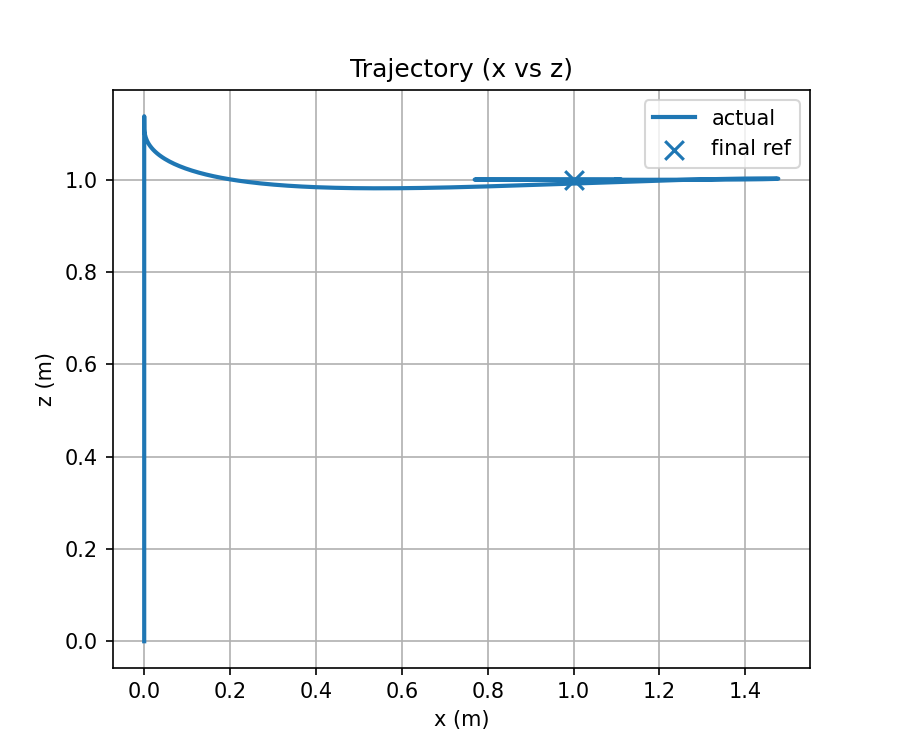

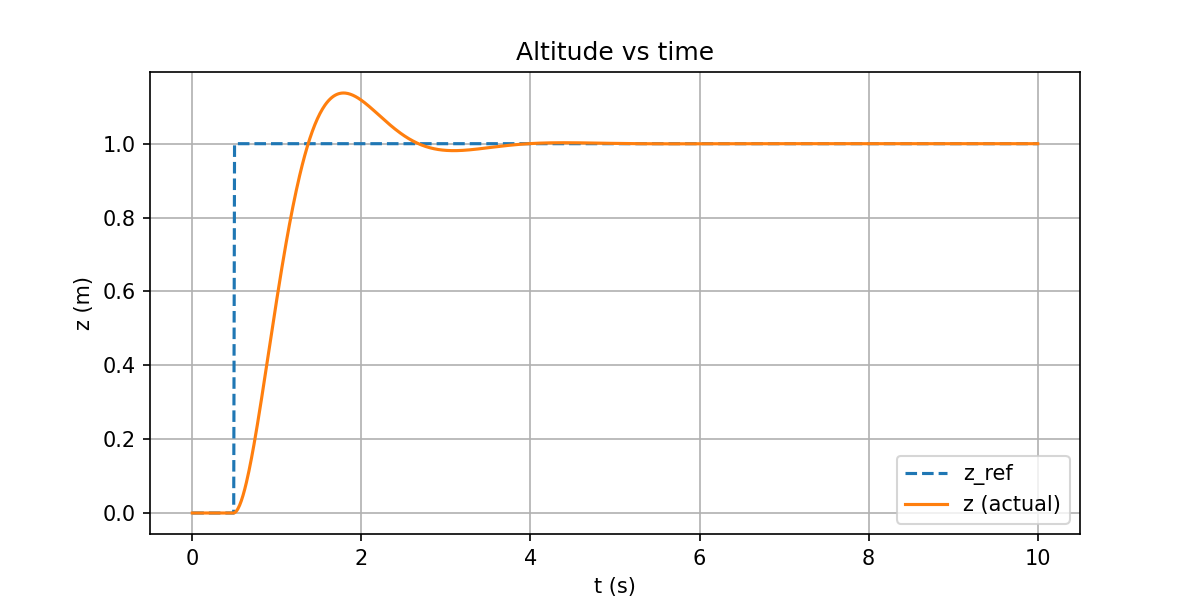

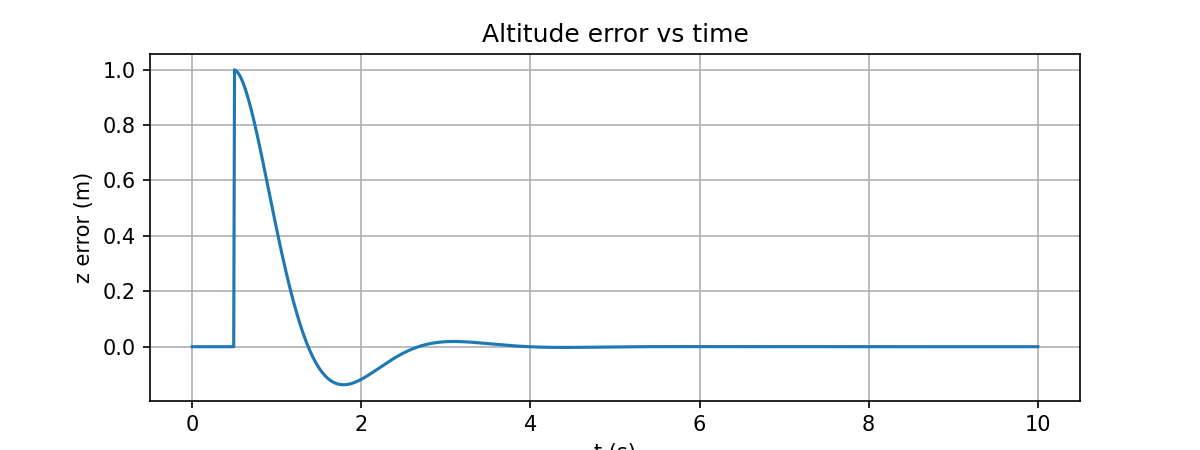

In [3]:

# --- Analysis: compute RMSE, overshoot, settling time ---
import pandas as pd
import numpy as np

df = pd.read_csv('flight_log.csv')

# RMSE position
rmse = np.sqrt(np.mean((df['x'] - df['x_ref'])**2 + (df['z'] - df['z_ref'])**2))
print(f'RMSE (position) = {rmse:.4f} m')

# overshoot in z
z_ref_final = df['z_ref'].iloc[-1]
z_max = df['z'].max()
overshoot = (z_max - z_ref_final) / (z_ref_final + 1e-8) * 100.0
print(f'z overshoot = {overshoot:.2f} %')

# settling time (2% band)
err = np.abs(df['z_ref'] - df['z'])
tol = 0.02 * (z_ref_final if z_ref_final!=0 else 1.0)
settling_idx = np.where(err <= tol)[0]
if settling_idx.size > 0:
    settling_time = df['t'].iloc[settling_idx[0]]
else:
    settling_time = np.nan
print(f'approx settling time = {settling_time:.3f} s')

# Show images inline (if in Colab)
from IPython.display import Image, display
display(Image('plots/trajectory.png'))
display(Image('plots/z_vs_time.png'))
display(Image('plots/z_error.png'))


## Next steps

- Tweak gains `Kp_z, Kd_z, Kp_x` etc. and re-run to see changes.
- Run a parameter sweep and save `results.csv` for optimization.
- Use the generated `flight_log.csv` with an `analysis.ipynb` for richer metrics.

### To export to GitHub
1. Download the notebook: File -> Download .ipynb
2. Create a repo and upload the notebook and the `plots/` images.
3. Add a short `README.md` summarizing the findings and a demo GIF or mp4.
